In [1]:
from sklearn.preprocessing import LabelEncoder
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
import pyjags

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

test_size=0.3
random_state=42



ModuleNotFoundError: No module named 'pyjags'

In [3]:
# set the data type
dtypes = {'city_development_index': 'float', 
          'city':'str',
          'gender':'str',
          'relevent_experience':'str',
          'training_hours': 'float', 
          'target': 'int', 
          'enrolle_id': 'int',
          'city':'str',
          'enrollee_id':'str',
          'enrolled_university':'str',
          'education_level':'str', 
          'major_discipline':'str',
          'experience':'str',
          'company_size':'str',
          'last_new_job':'str'}

# read data
df_train = pd.read_csv("data//aug_train.csv", dtype=dtypes)
df_test = pd.read_csv("data//aug_test.csv", dtype=dtypes)

# different categorical data
con = ['city_development_index', 'training_hours']
cat = ['gender', 'relevent_experience', 'enrolled_university', 'education_level', 
       'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']

df_train.head(3)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36.0,1
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47.0,0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83.0,0


In [4]:
# missing values
(df_train.isnull().sum()/df_train.shape[0]).sort_values(ascending=False).round(4)[:9]

company_type           0.3205
company_size           0.3099
gender                 0.2353
major_discipline       0.1468
education_level        0.0240
last_new_job           0.0221
enrolled_university    0.0201
experience             0.0034
enrollee_id            0.0000
dtype: float64

In [5]:
def label_encode(train, test):
    """
    encoding the string values. it returns dataframe which are encoded and dictionary object save results.
    
    args:
        train: trainning dataset.
        test: test dataset.
    
    returns:
        train: traning dataset after encoding processes.
        test: test dataset after encoding processes.
        label_dict: the dict object save encoding result. where key repersents column name, and value represent encoding label.
    """
    label_dict = {}
    
    for column in ['city', 'gender', 'education_level', 'major_discipline','experience', 'relevent_experience', 
                   'company_size', 'company_type', 'last_new_job', 'training_hours','enrolled_university']:
        # initialize object
        le = LabelEncoder()
        le.fit(train[column])
        
        label_dict[column] = le.classes_
        
        # transfer columns
        train[column] = le.transform(train[column]).astype(int)
        test[column] = le.transform(test[column]).astype(int)
    return train, test, label_dict

df_train_notna, df_test_notna, labels = label_encode(df_train.dropna(), df_test.dropna())

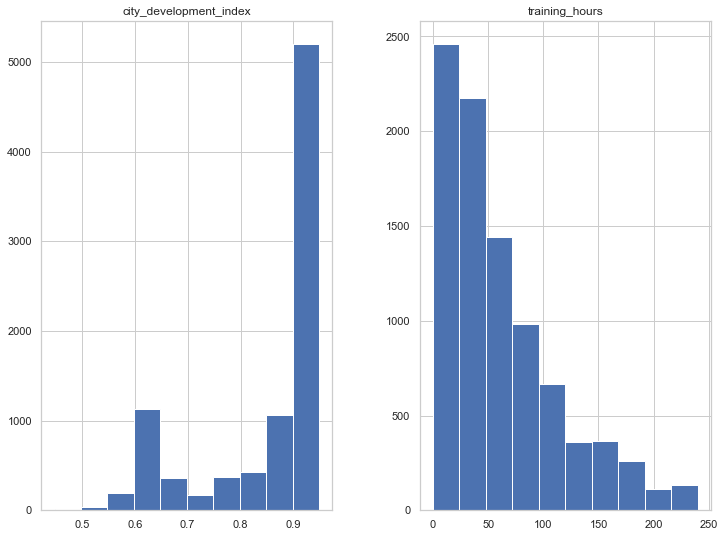

In [6]:
# continuous data
df_train_notna[con].hist(figsize=(12,9));

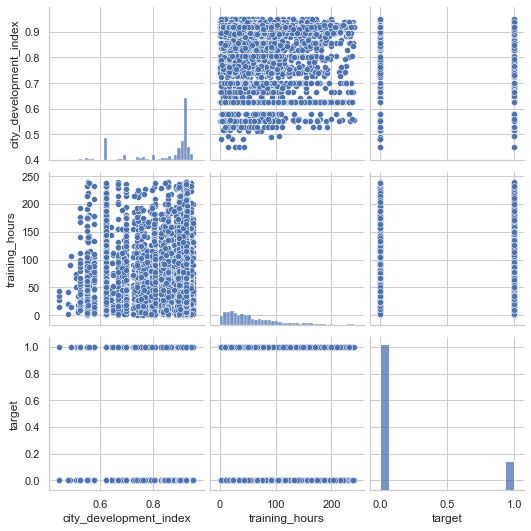

In [7]:
sns.pairplot(df_train_notna[con+['target']]);

In [8]:
def transfer_cat_type(train, test, cat=cat):
    """transfer data type to categoical data, the function return datasets which are categorical values."""
    for column in train[cat].columns:
        train[column] = train[column].astype(int)
        test[column] = test[column].astype(int)
    return train, test 
df_train_notna, df_test_notna = transfer_cat_type(df_train_notna, df_test_notna)

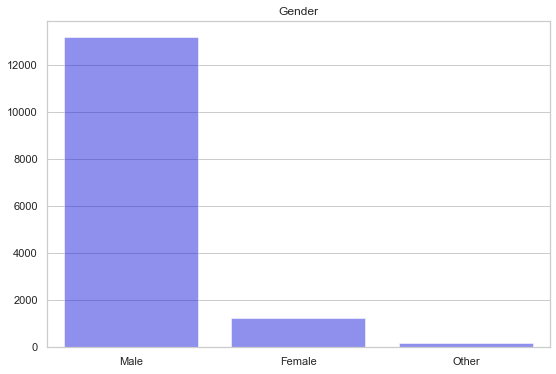

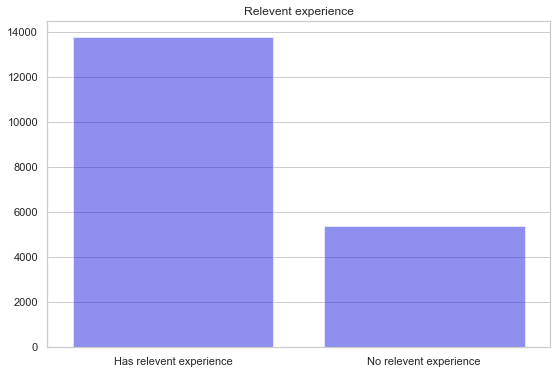

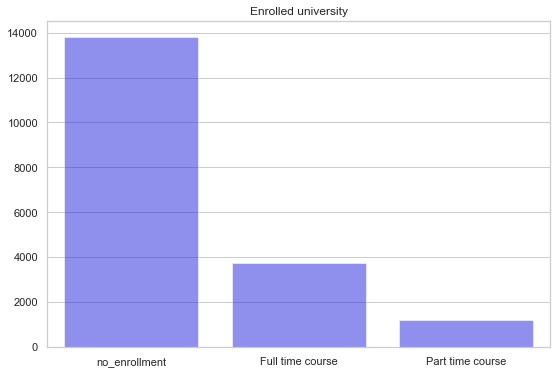

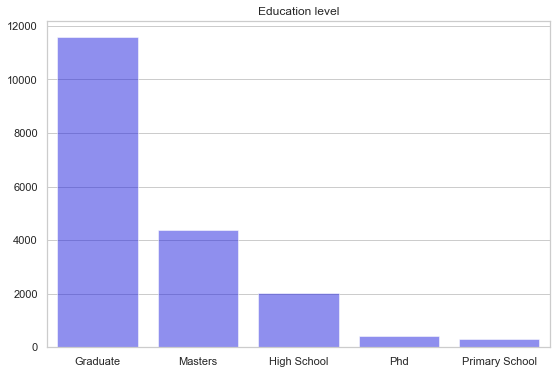

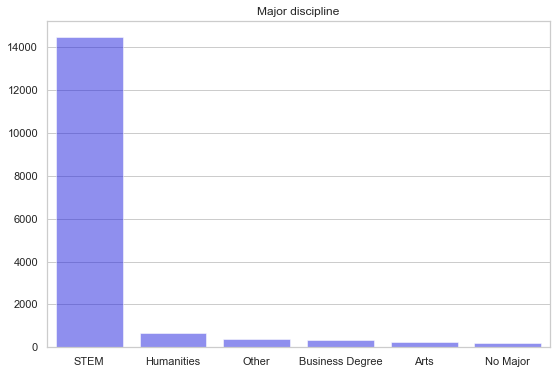

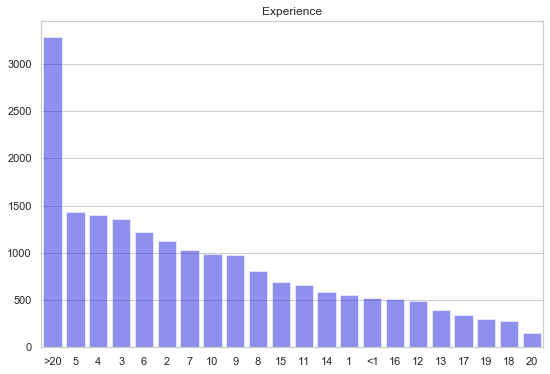

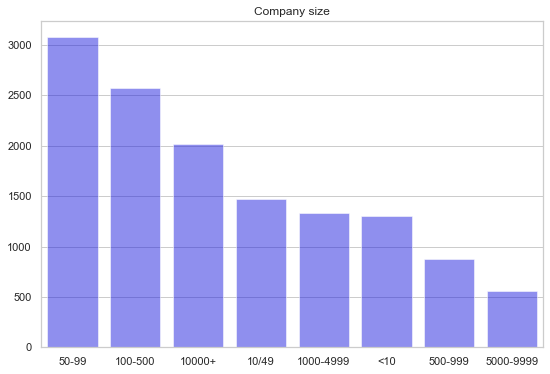

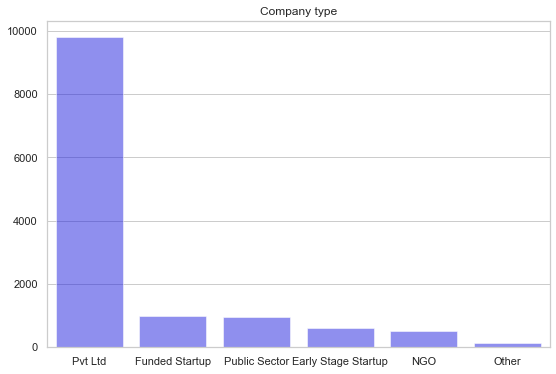

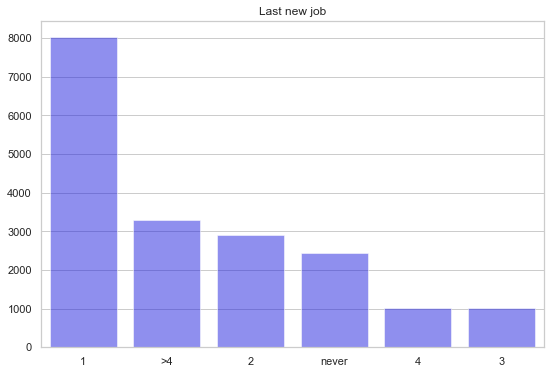

In [9]:
# categorical data
def draw_cat_data(df):
    """this function draw categorical values."""
    for column in cat:
        # get x and y label
        temp =  df[column].value_counts()
        x = temp.index
        y = temp.values
        
        # draw picture 
        plt.figure(figsize=(9,6))
        plt.title(column.capitalize().replace("_"," ") )
        sns.barplot(x=x, y=y, color='blue', alpha=0.5) 
        plt.show()
        
draw_cat_data(df_train)

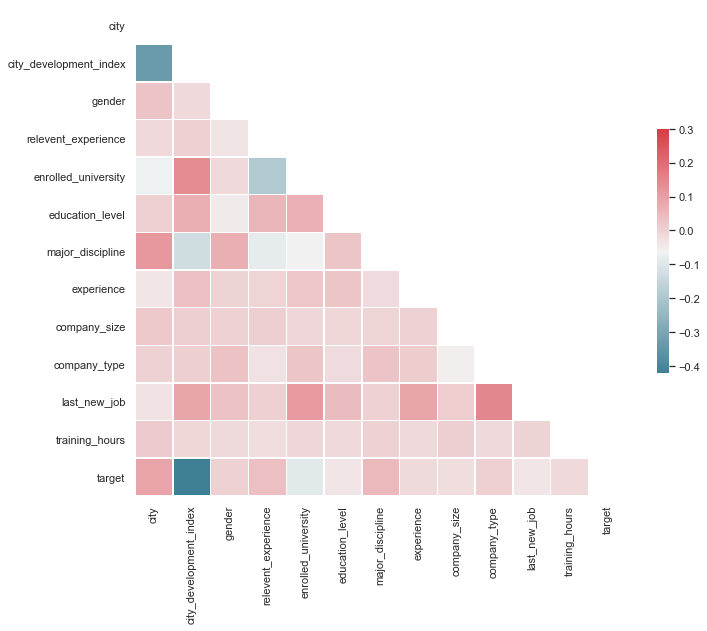

In [10]:
def correlation_heatmap(df):
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        vmax=0.3,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
        ax=ax);
    
correlation_heatmap(df_train_notna)

In [11]:
# train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

def baseline_model(X_train, X_test, y_train, y_test):
    parameters = {'l1_ratio':np.arange(0,1,0.01)}
    
    lr_l1 =LogisticRegression(fit_intercept = False, penalty='l1', solver='liblinear', max_iter = 4000)
    
    lr_clf_l1 = GridSearchCV(lr_l1, 
                             param_grid = parameters, 
                             cv = 3, 
                             return_train_score = True,
                             scoring = 'roc_auc',
                             n_jobs = -1)
    
    lr_clf_l1.fit(X_train, y_train)
    y_pred = lr_clf_l1.predict(X_test)
    
    lr_l1 = lr_clf_l1.best_estimator_
    
    print('model performance:')
    print(classification_report(y_test, y_pred))
    
    print('\ntraining result')
    print(pd.DataFrame(lr_clf_l1.cv_results_)[['mean_test_score','param_l1_ratio']].sort_values(by='mean_test_score',ascending=False).head(10))
    
    print('\ncoefficients ')
    coefficients = pd.DataFrame(index = list(X_train.columns), 
                       data = lr_l1.coef_.reshape(X_train.shape[1],1),
                       columns=['Coefficients'])
    print(coefficients.abs().\
          sort_values(by='Coefficients', ascending=False).head(20))
    return coefficients

X_train, X_test, y_train, y_test = train_test_split(df_train_notna.drop(['target'],axis=1), 
                                                    df_train_notna['target'].astype(int), test_size=test_size, random_state=random_state)

_ = baseline_model(X_train, X_test, y_train, y_test)

model performance:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      2250
           1       0.56      0.10      0.17       437

    accuracy                           0.84      2687
   macro avg       0.70      0.54      0.54      2687
weighted avg       0.80      0.84      0.79      2687


training result
    mean_test_score param_l1_ratio
1          0.752542           0.01
93         0.752512           0.93
2          0.752491           0.02
88         0.752482           0.88
4          0.752476           0.04
59         0.752451           0.59
21         0.752429           0.21
54         0.752421           0.54
15         0.752407           0.15
48         0.752407           0.48

coefficients 
                        Coefficients
city_development_index      6.366037
major_discipline            0.476313
relevent_experience         0.380269
gender                      0.321832
company_type                0.104366
enrolled_univer

In [12]:
def get_dummy_variables(train, test, cat_ls):
    train_dummies = pd.get_dummies(train[cat_ls],  drop_first = True)
    test_dummies = pd.get_dummies(test[cat_ls], drop_first = True)
    
    train.drop(cat_ls, axis=1, inplace=True)
    test.drop(cat_ls, axis=1, inplace=True)
    
    dummy_ls = list(train_dummies.columns)
    
    train = train.join(train_dummies)
    test = test.join(test_dummies)
    return train, test, dummy_ls

df_train_dummy, df_test_dummy, cat_dummy = get_dummy_variables(df_train, df_test, cat) 
df_train_dummy, df_test_dummy = transfer_cat_type(df_train_dummy, df_test_dummy, cat_dummy)

In [13]:
from sklearn.preprocessing import PolynomialFeatures

def get_poly_variables(train, test, ls, degree=3):
    poly = PolynomialFeatures(degree=degree)
    
    train_ploy = poly.fit_transform(train[ls])
    test_poly = poly.transform(test[ls])
    
    feature_ls = poly.get_feature_names()
    
    for i1, name in enumerate(ls):
        for i2 in range(len(feature_ls)):
            feature_ls[i2] = feature_ls[i2].replace('x'+ str(i1), name)
    
    # drop first order variable
    feature_ls=feature_ls[len(ls)+1: ]
    train_ploy,test_poly = train_ploy[:,len(ls)+1:], test_poly[:,len(ls)+1:]
    
    train = train.join(pd.DataFrame(train_ploy, columns=feature_ls, index=train.index))
    test = test.join(pd.DataFrame(test_poly, columns=feature_ls, index=test.index))
    
    train['intercept'], test['intercept'] = 1, 1
    return train, test

df_train_dummy_poly,df_test_dummy_poly = get_poly_variables(df_train_dummy, df_test_dummy,con)

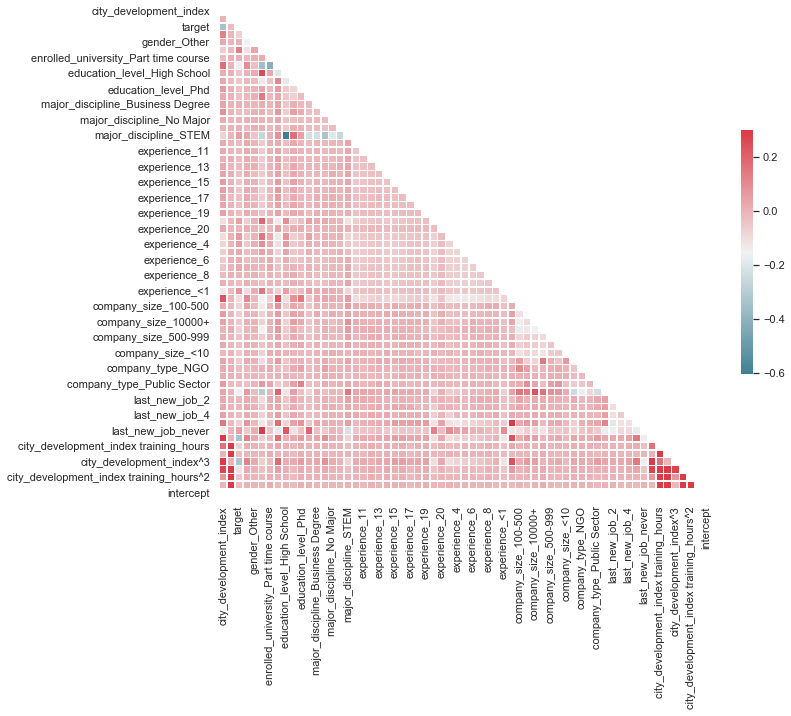

In [14]:
correlation_heatmap(df_train_dummy_poly)

In [15]:
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(df_train_dummy_poly.drop(['target','city','enrollee_id'],axis=1), df_train_dummy_poly['target'].astype(int), 
                                                    test_size=0.3, random_state=42)

lr_1_coeffs = baseline_model(X_train_fe, X_test_fe, y_train_fe, y_test_fe)

model performance:
              precision    recall  f1-score   support

           0       0.79      0.93      0.85      4300
           1       0.56      0.25      0.35      1448

    accuracy                           0.76      5748
   macro avg       0.68      0.59      0.60      5748
weighted avg       0.73      0.76      0.73      5748


training result
    mean_test_score param_l1_ratio
36         0.779406           0.36
85         0.779400           0.85
71         0.779252           0.71
12         0.779063           0.12
79         0.779060           0.79
24         0.779059           0.24
63         0.779044           0.63
80         0.778962           0.80
84         0.778878           0.84
37         0.778841           0.37

coefficients 
                                  Coefficients
city_development_index^2              1.950119
intercept                             1.753639
city_development_index^3              1.009260
company_size_<10                      0.956125
co

In [16]:
data = X_train_fe.join(y_train_fe)

with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(
        "target ~  city_development_index + intercept", data[['target', 'city_development_index', 'intercept']], family=pm.glm.families.Binomial()
    )
    trace = pm.sample(1000, tune=1000, init="adapt_diag")

NameError: name 'pm' is not defined

In [72]:
X_train_fe.dtypes.drop('')

enrollee_id                                 object
city_development_index                     float64
training_hours                             float64
gender_Male                                  int32
gender_Other                                 int32
                                            ...   
city_development_index^3                   float64
city_development_index^2 training_hours    float64
city_development_index training_hours^2    float64
training_hours^3                           float64
intercept                                    int64
Length: 63, dtype: object